In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [77]:
cols = ["flength", "fwidth", "fsize", "fconc", "fconc1", "fAsym", "fM3long", "fM3trans", "fAlpha", "fdist", "class"]
df = pd.read_csv('magic04.data', names = cols)

In [78]:
# df['class'].unique()
df["class"] = df["class"].replace({'g' : 1, 'h' : 0})
# df.head()

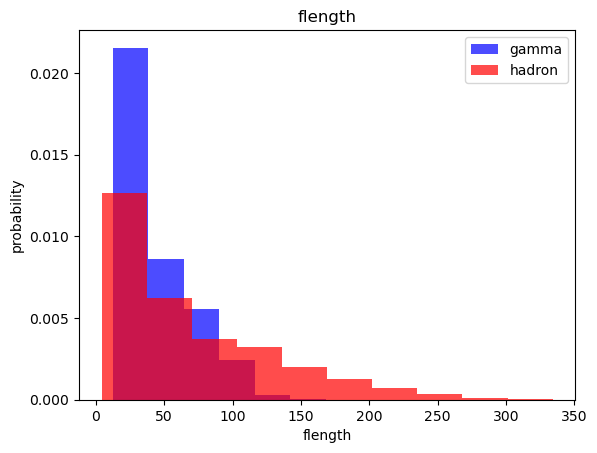

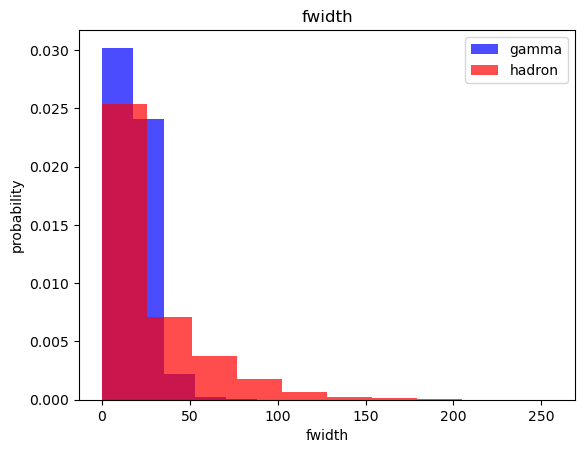

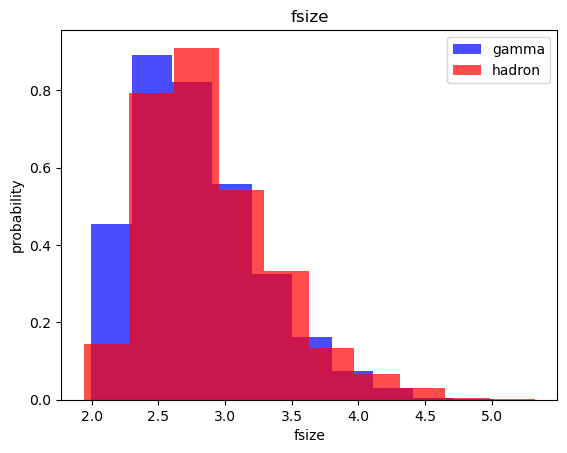

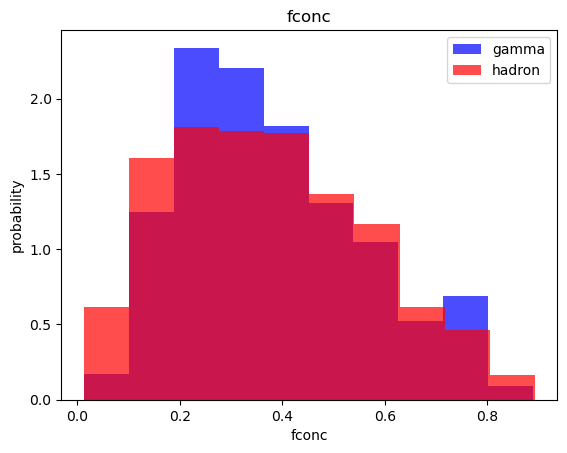

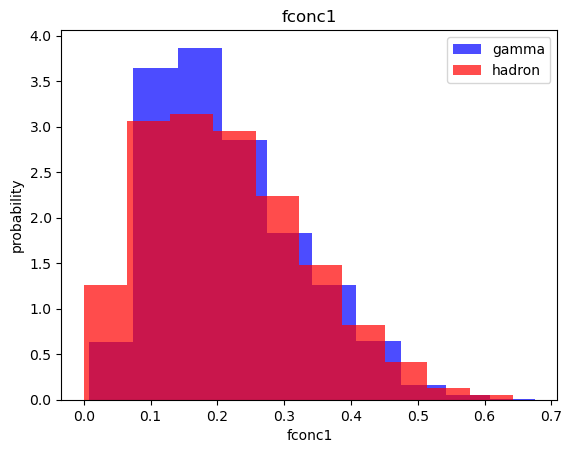

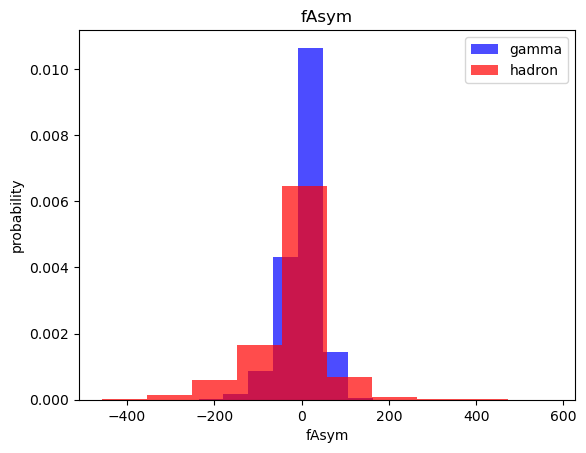

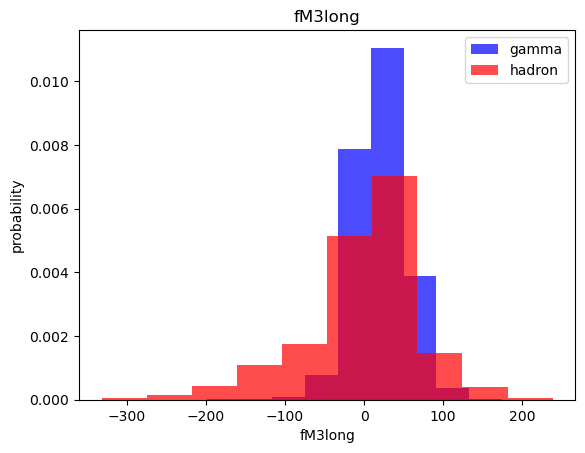

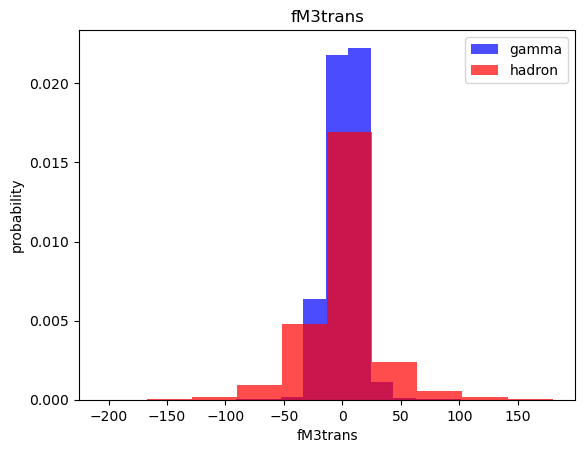

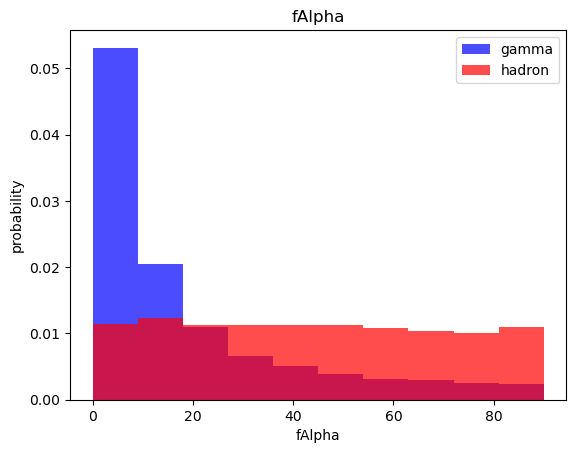

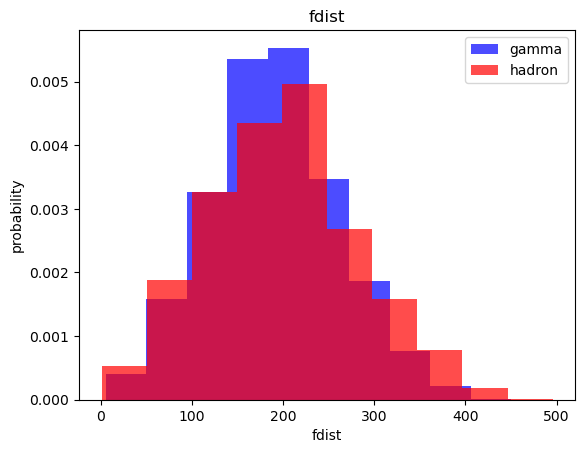

In [79]:
for label in cols[:-1]:
    plt.hist(df[df['class'] == 1][label], color = 'blue', label = 'gamma', density = True, alpha = 0.7)
    plt.hist(df[df['class'] == 0][label], color = 'red', label = 'hadron', density = True, alpha = 0.7)
    plt.title(label)
    plt.ylabel("probability")
    plt.xlabel(label)
    plt.legend()
    plt.show()

### Building the Training, Validation and Test datasets:

In [80]:
train, valid, test = np.split(df.sample(frac = 1), [int(0.6*len(df)), int(0.8*len(df))])

#### rescaling the data:
Since our data had columns that have different scales, which can cause problems in the machine learning process, we are going to rescale them, by first defining a rescaling function, and then running our dataframe through it.

In [81]:
def scale_dataset (dataframe, oversample = False):
    x = dataframe[dataframe.columns[:-1]].values
    y = dataframe[dataframe.columns[-1]].values
    scaler = StandardScaler()
    x = scaler.fit_transform(x)

    if oversample:
        ros = RandomOverSampler()
        x,y = ros.fit_resample(x,y)
    
    data = np.hstack((x, np.reshape(y,(-1,1))))
    return data,x,y

Now, let's have a look at how many hadrons vs gammas we have in our dataset:

In [82]:
# print(len(train[train['class'] == 1]), ", ",
# len(train[train['class'] == 0]))

Since the data is imbalanced (imbalanced binary classification), we oversampled the minority and/or undersampled the majority in order to avoid bias. 

In [83]:
train, x_train, y_train = scale_dataset(train, oversample = True)

In [84]:
print(sum(y_train == 1), ", ", sum(y_train == 0))

7397 ,  7397


And so, the data is now balanced. <br/>
We can do the same thing to our other 2 datasets, however, we aren't going to set oversample = True in these, as we want our model to be able to perform on real data:

In [85]:
valid, x_valid, y_valid = scale_dataset(valid)
test, x_test, y_test = scale_dataset(test)

## Applying ML models:

### 1. k-nearest neighbours:

In [86]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [87]:
# help(KNeighborsClassifier())

In [88]:
knn_model = KNeighborsClassifier(n_neighbors = 5)
knn_model.fit(x_train, y_train)

KNeighborsClassifier()

In [89]:
y_pred = knn_model.predict(x_test)
# print(y_pred, "\n", Y_test)

In [90]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1322
           1       0.86      0.86      0.86      2482

    accuracy                           0.82      3804
   macro avg       0.80      0.80      0.80      3804
weighted avg       0.82      0.82      0.82      3804



### Naive Bayes:

In [91]:
from sklearn.naive_bayes import GaussianNB

In [92]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train, y_train)

In [93]:
y_pred = nb_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.42      0.52      1322
           1       0.74      0.90      0.81      2482

    accuracy                           0.73      3804
   macro avg       0.71      0.66      0.66      3804
weighted avg       0.72      0.73      0.71      3804



### Logistic Regression:

In [94]:
from sklearn.linear_model import LogisticRegression

In [110]:
lg_model = LogisticRegression()
lg_model = nb_model.fit(x_train, y_train)

In [112]:
y_pred = lg_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.42      0.52      1322
           1       0.74      0.90      0.81      2482

    accuracy                           0.73      3804
   macro avg       0.71      0.66      0.66      3804
weighted avg       0.72      0.73      0.71      3804



### SVM:

In [117]:
from sklearn.svm import SVC
# SVC = support vector classifier

In [118]:
svm_model = SVC()
svm_model = svm_model.fit(x_train, y_train)

In [119]:
y_pred = svm_model.predict(x_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      1322
           1       0.89      0.89      0.89      2482

    accuracy                           0.86      3804
   macro avg       0.84      0.85      0.85      3804
weighted avg       0.86      0.86      0.86      3804



So these are the various models that we can use and explore the different parameters of, in order to fine tune it according to the data set and to improve the results.
However these models give us around 70-80% accuracy, with SVM being the most accurate so far.

### Neural Network:

In [120]:
import tensorflow as tf

2023-11-08 17:56:01.684624: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [162]:
def plot_history(history):
    fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,4))
    ax1.plot(history.history['loss'], label = 'loss')
    ax1.plot(history.history['val_loss'], label = 'val_loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Binary Crossentropy')
    ax1.legend()
    ax1.grid(True)
    

    ax2.plot(history.history['accuracy'], label = 'accuracy')
    ax2.plot(history.history['val_accuracy'], label = 'val_accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.show()

In [125]:
nm_model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu', input_shape = (10,)),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
                               ])

nm_model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'binary_crossentropy', metrics = ['accuracy'])

In [129]:
history = nm_model.fit(
    x_train, y_train,
    epochs = 100, batch_size = 32, validation_split = 0.2, verbose = 0
)

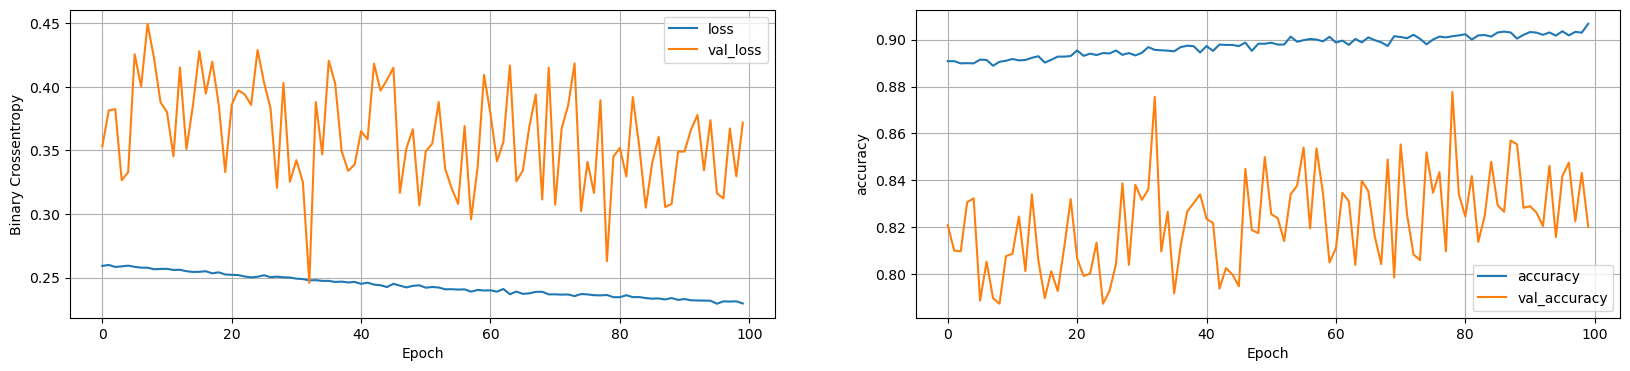

In [163]:
plot_history(history)
# plot_accuracy(history)

So, it makes sense that the validation dataset has worse results compared to the training dataset, as it is data that it hasn't seen yet. <br/>
Alse, we want to tune this neural network, and see what happens when we tweak around the parameters.



#### Grid search:

In [168]:
def train_model(x_train, y_train, num_nodes,dropout_prob, lr, batch_size, epochs):
    nm_model = tf.keras.Sequential([
        tf.keras.layers.Dense(num_nodes, activation = 'relu', input_shape = (10,)),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(num_nodes, activation = 'relu'),
        tf.keras.layers.Dropout(dropout_prob),
        tf.keras.layers.Dense(1, activation = 'sigmoid')
                                   ])
    
    nm_model.compile(optimizer = tf.keras.optimizers.Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy'])

    history = nm_model.fit(
    x_train, y_train, epochs = epochs, batch_size = batch_size, validation_split = 0.2, verbose = 0)

    return nm_model, history

In [165]:
%load_ext jupyternotify

<IPython.core.display.Javascript object>

number of nodes = 16, dropout probability = 0, learning rate = 0.01, batch size = 32, epochs = 100


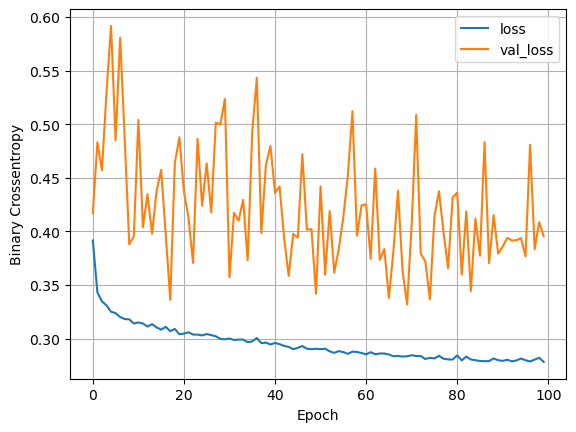

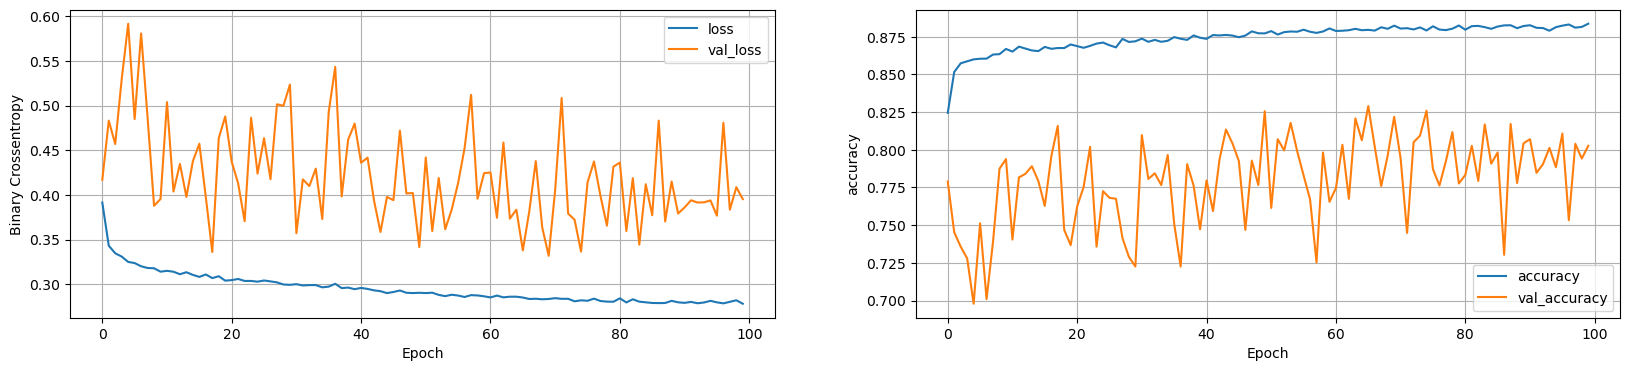

119/119 [==============================] - 2s 15ms/step - loss: 0.3219 - accuracy: 0.8746
number of nodes = 16, dropout probability = 0, learning rate = 0.01, batch size = 64, epochs = 100


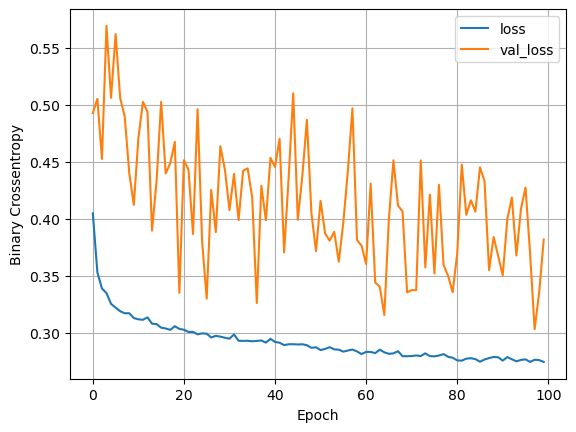

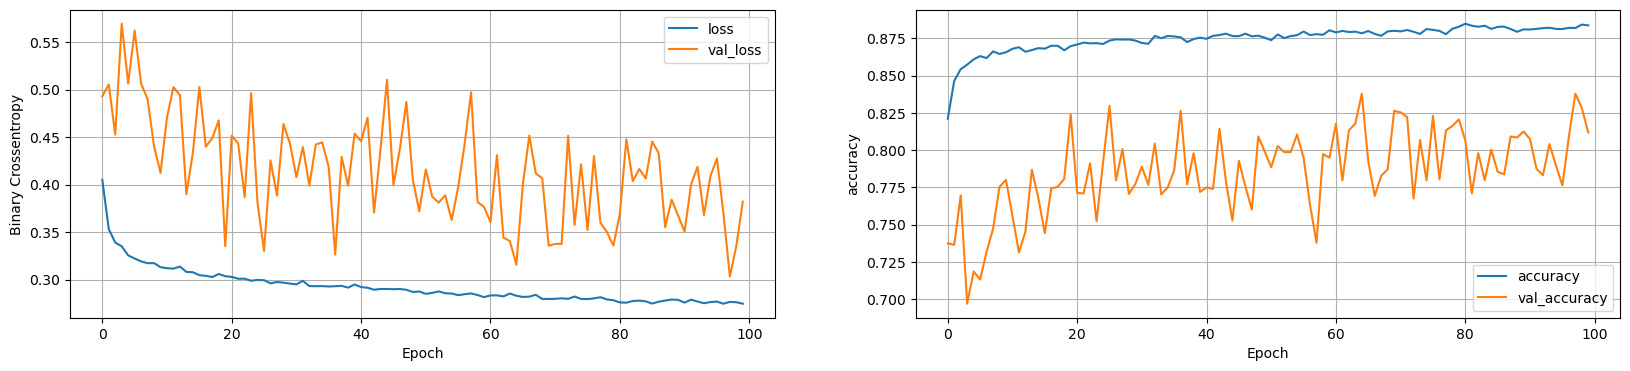

119/119 [==============================] - 2s 13ms/step - loss: 0.3307 - accuracy: 0.8651
number of nodes = 16, dropout probability = 0, learning rate = 0.01, batch size = 128, epochs = 100


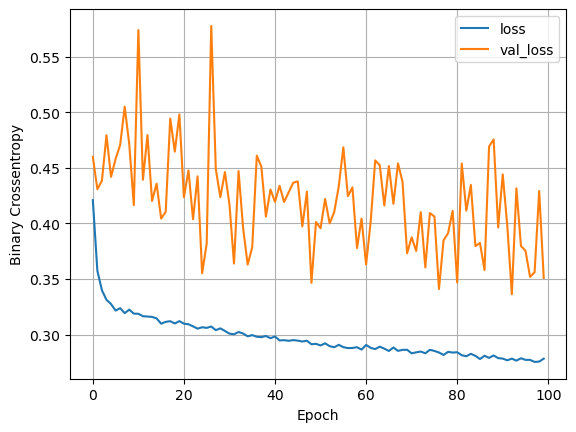

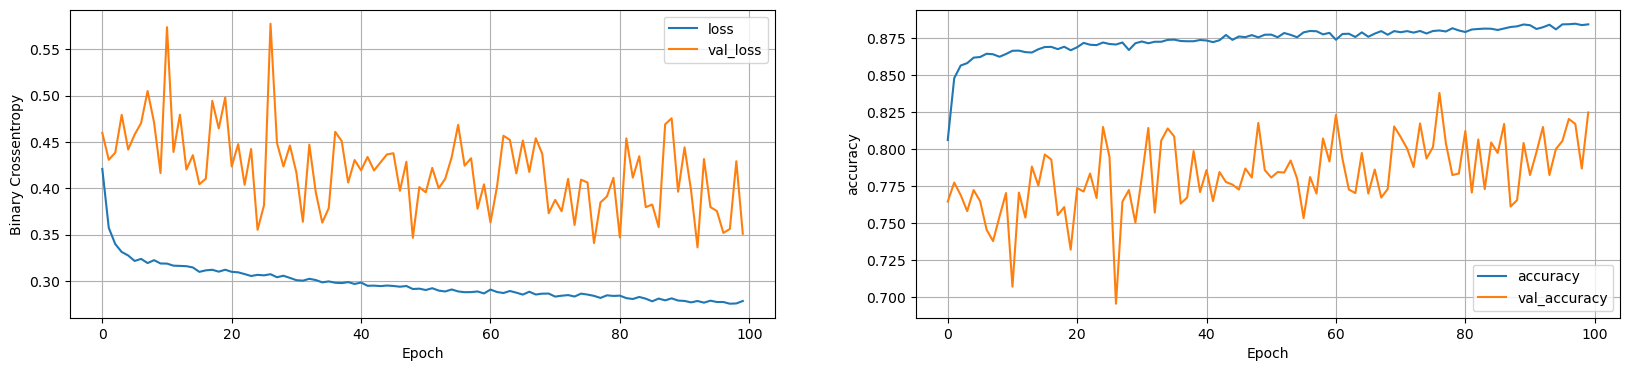

119/119 [==============================] - 2s 14ms/step - loss: 0.3230 - accuracy: 0.8701
number of nodes = 16, dropout probability = 0, learning rate = 0.001, batch size = 32, epochs = 100


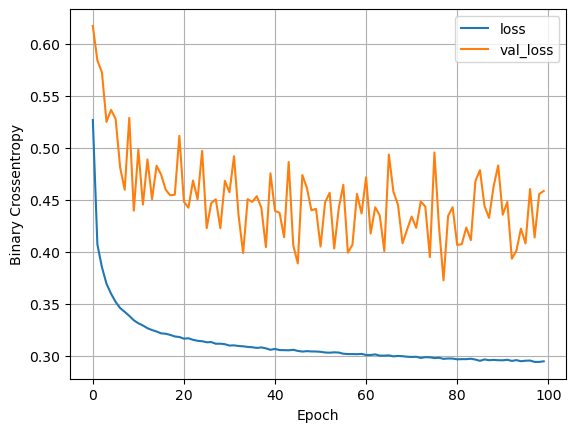

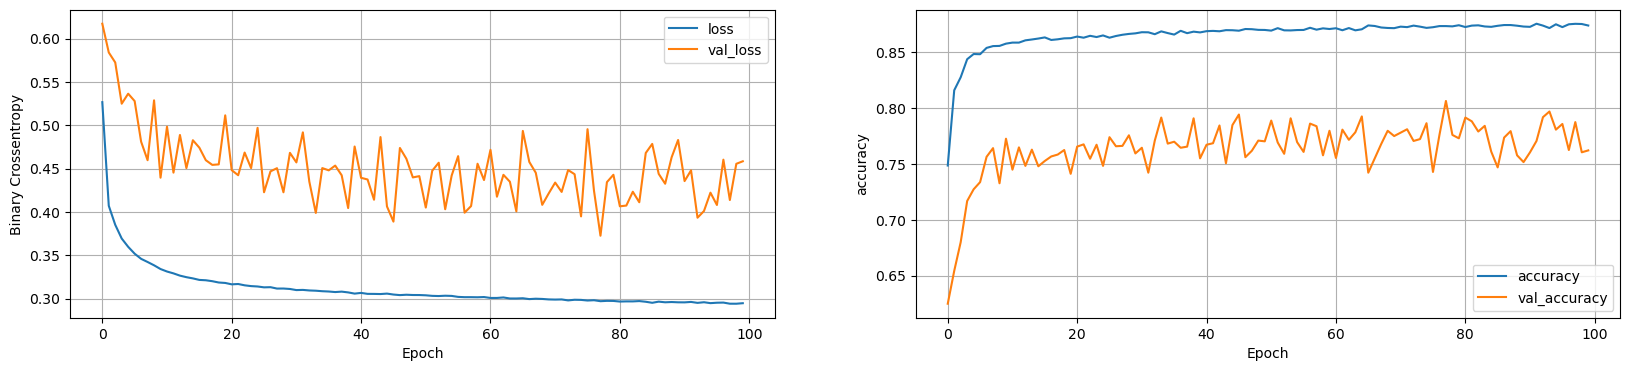

119/119 [==============================] - 1s 12ms/step - loss: 0.3195 - accuracy: 0.8691
number of nodes = 16, dropout probability = 0, learning rate = 0.001, batch size = 64, epochs = 100


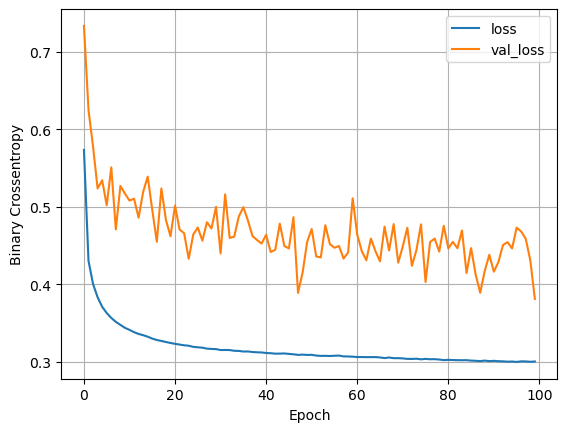

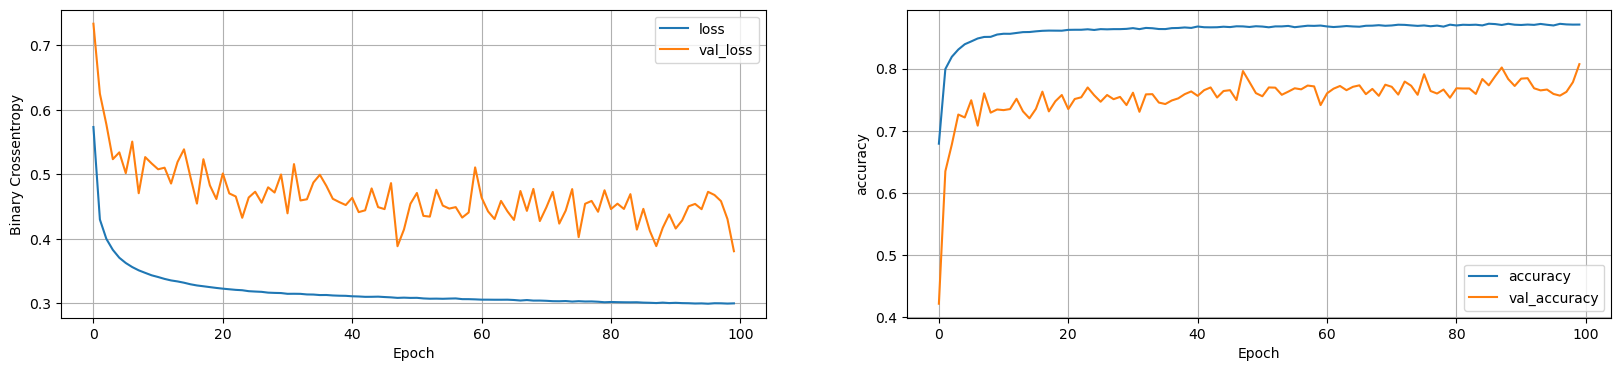

119/119 [==============================] - 2s 13ms/step - loss: 0.3258 - accuracy: 0.8620
number of nodes = 16, dropout probability = 0, learning rate = 0.001, batch size = 128, epochs = 100


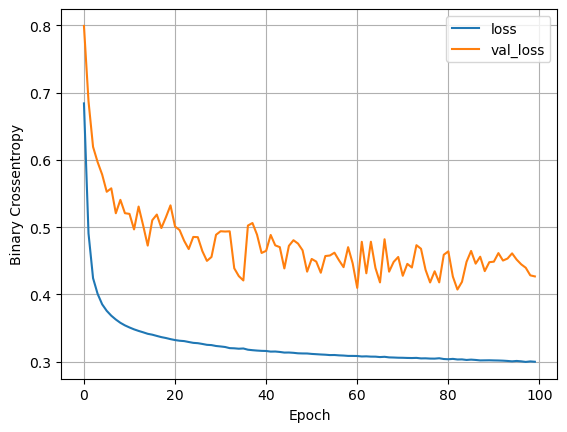

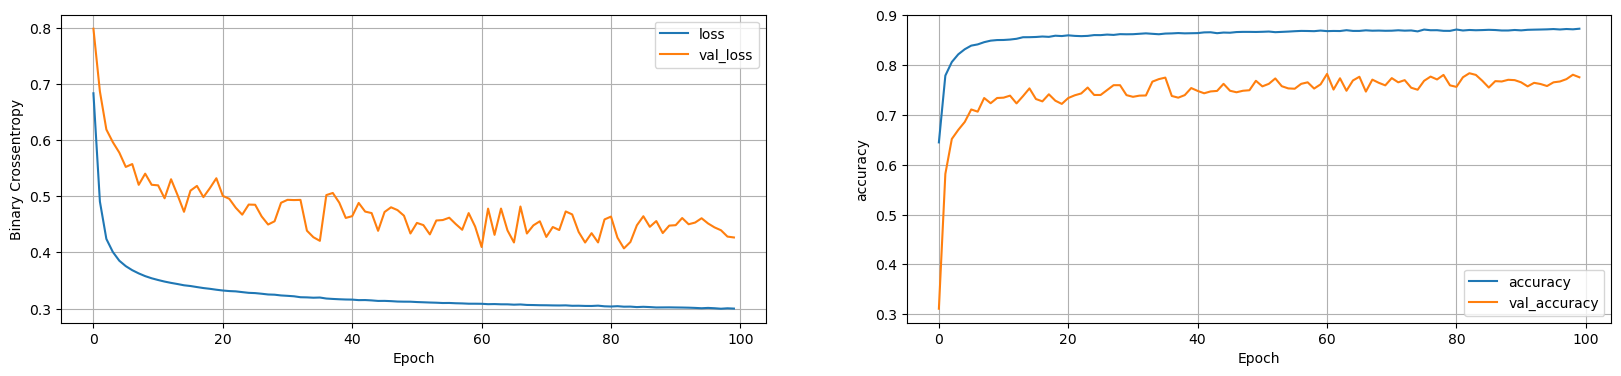

119/119 [==============================] - 2s 16ms/step - loss: 0.3167 - accuracy: 0.8709
number of nodes = 16, dropout probability = 0, learning rate = 0.005, batch size = 32, epochs = 100


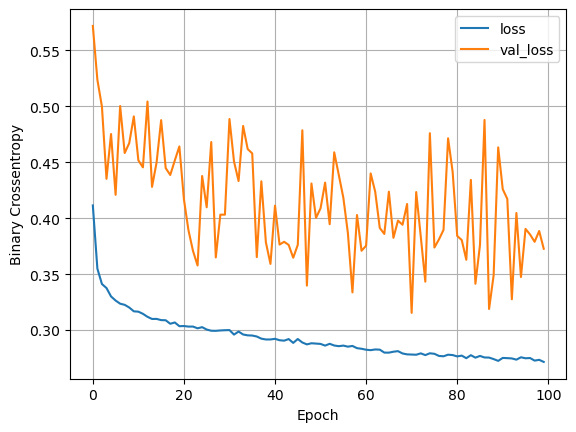

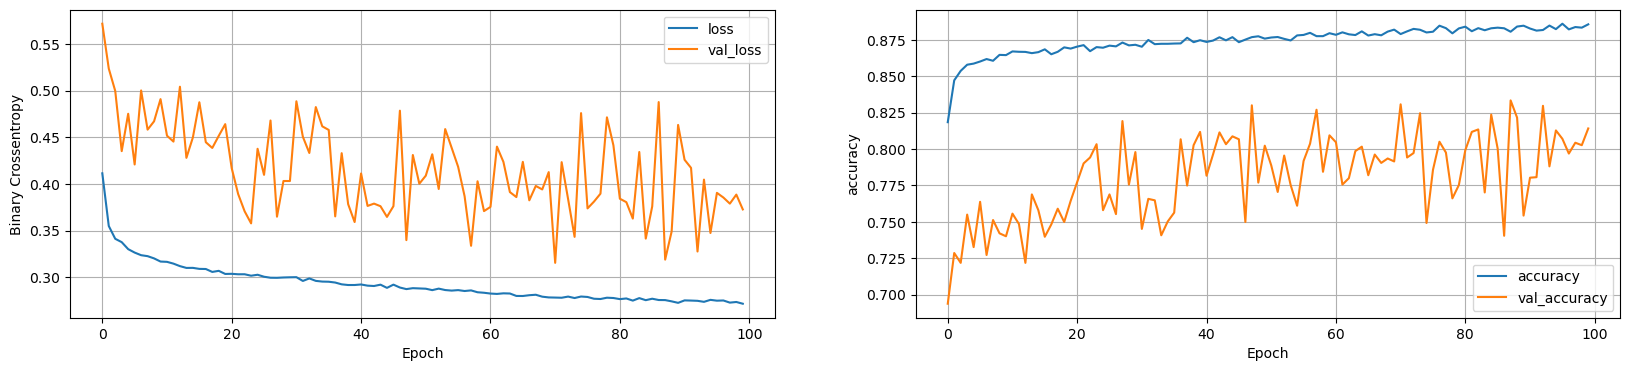

119/119 [==============================] - 1s 11ms/step - loss: 0.3346 - accuracy: 0.8728
number of nodes = 16, dropout probability = 0, learning rate = 0.005, batch size = 64, epochs = 100


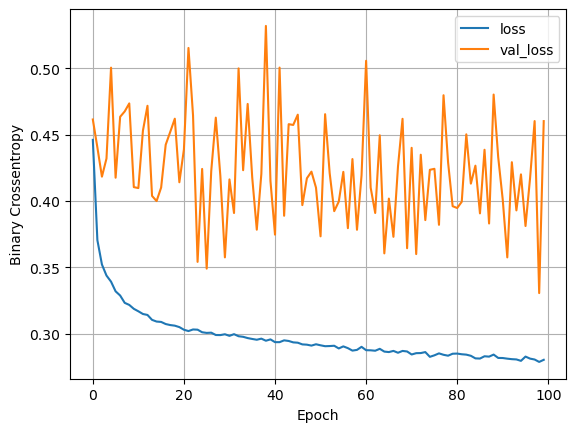

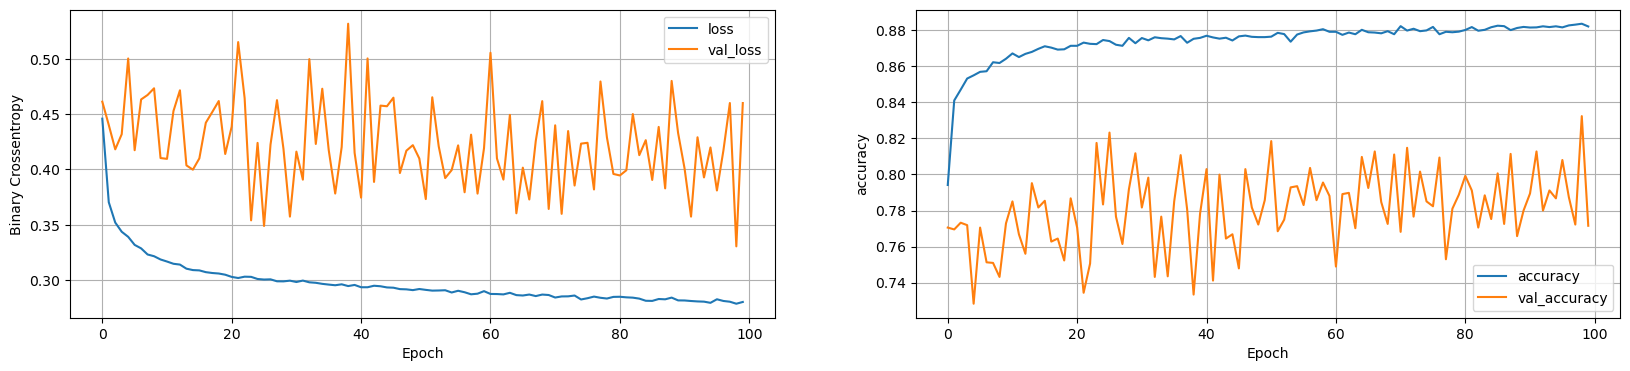

119/119 [==============================] - 2s 16ms/step - loss: 0.3198 - accuracy: 0.8701
number of nodes = 16, dropout probability = 0, learning rate = 0.005, batch size = 128, epochs = 100


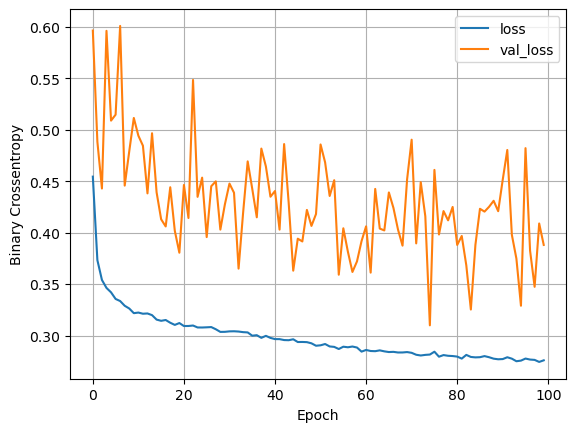

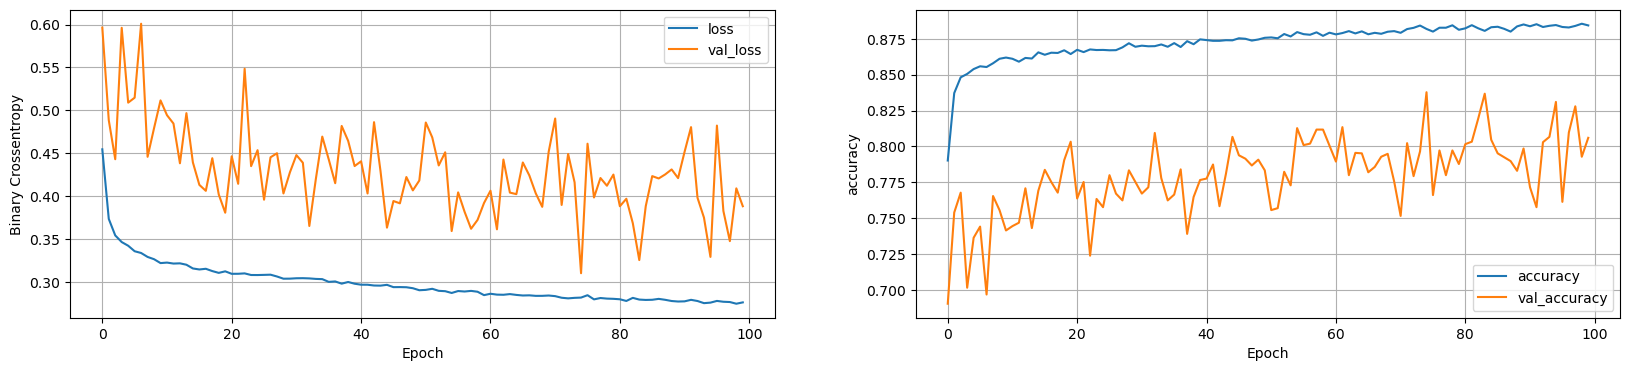

119/119 [==============================] - 2s 19ms/step - loss: 0.3134 - accuracy: 0.8775
number of nodes = 16, dropout probability = 0.2, learning rate = 0.01, batch size = 32, epochs = 100


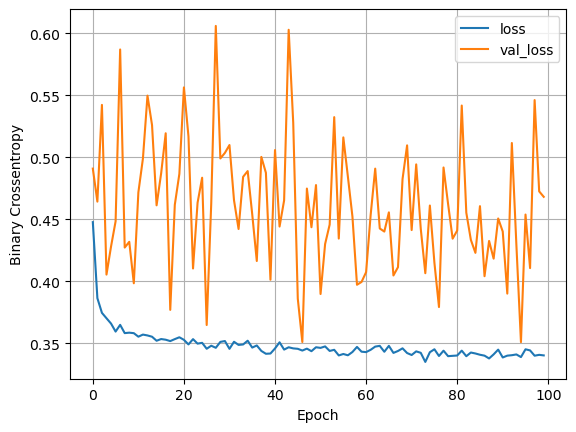

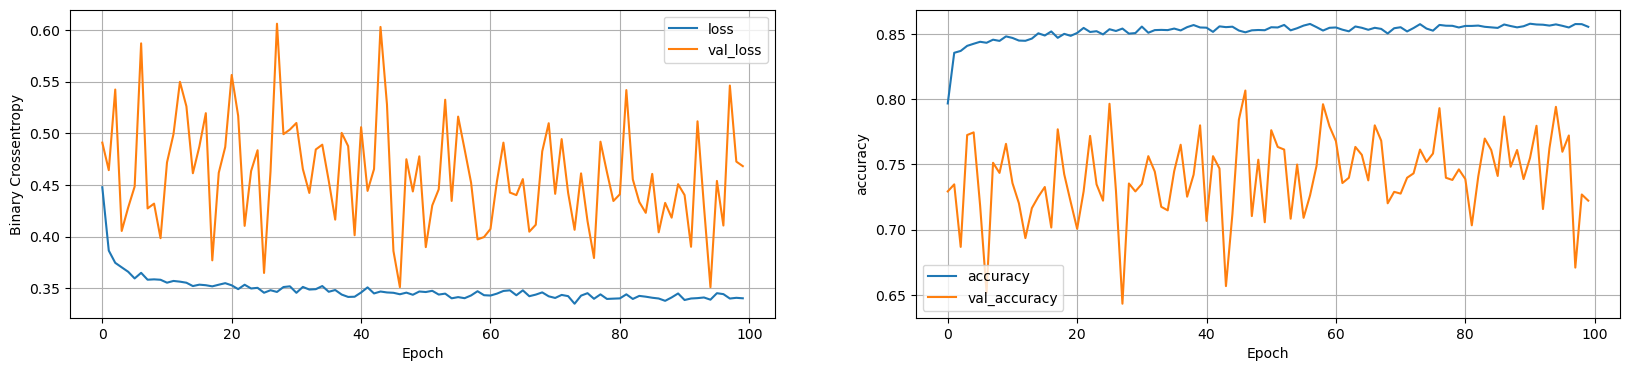

119/119 [==============================] - 2s 14ms/step - loss: 0.3264 - accuracy: 0.8670
number of nodes = 16, dropout probability = 0.2, learning rate = 0.01, batch size = 64, epochs = 100


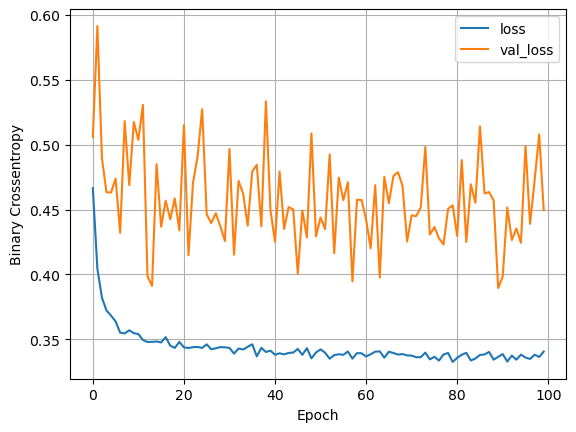

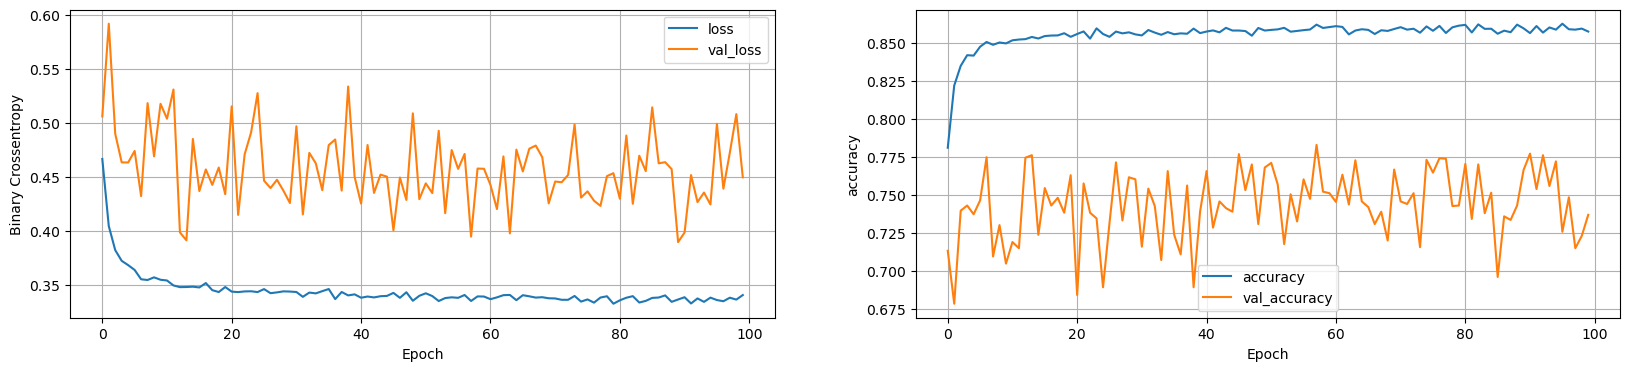

119/119 [==============================] - 2s 15ms/step - loss: 0.3145 - accuracy: 0.8725
number of nodes = 16, dropout probability = 0.2, learning rate = 0.01, batch size = 128, epochs = 100


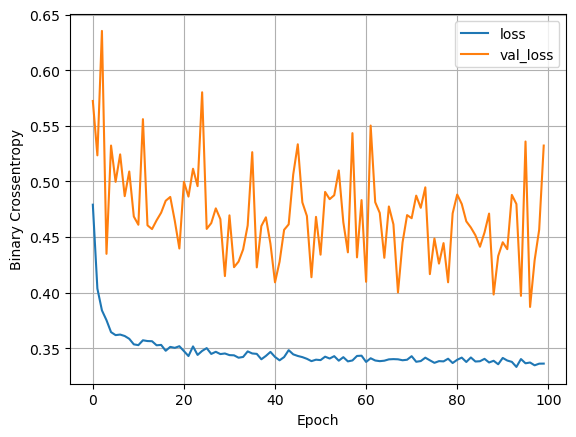

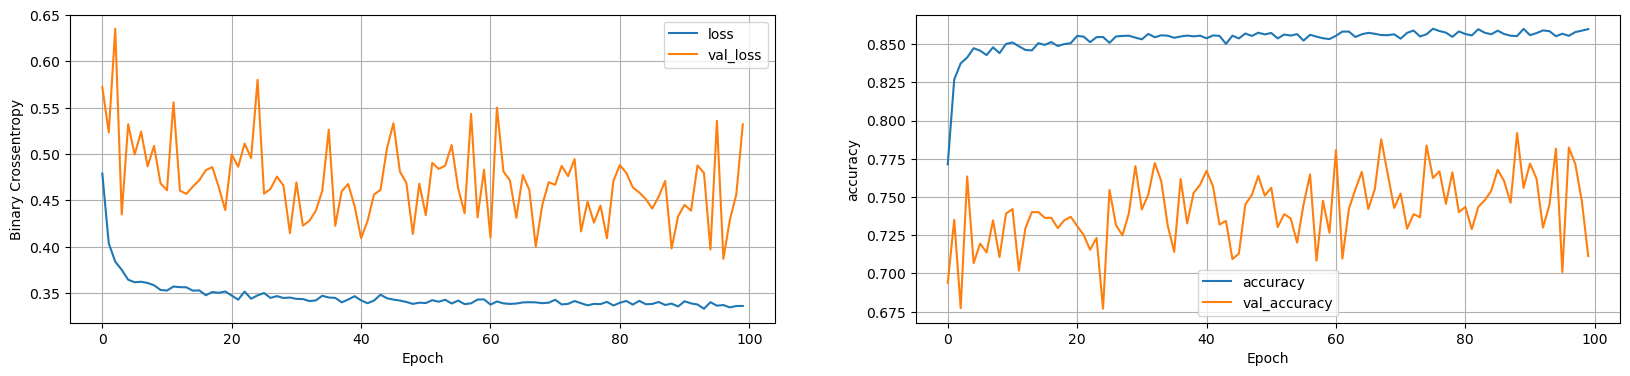

119/119 [==============================] - 2s 15ms/step - loss: 0.3303 - accuracy: 0.8630
number of nodes = 16, dropout probability = 0.2, learning rate = 0.001, batch size = 32, epochs = 100


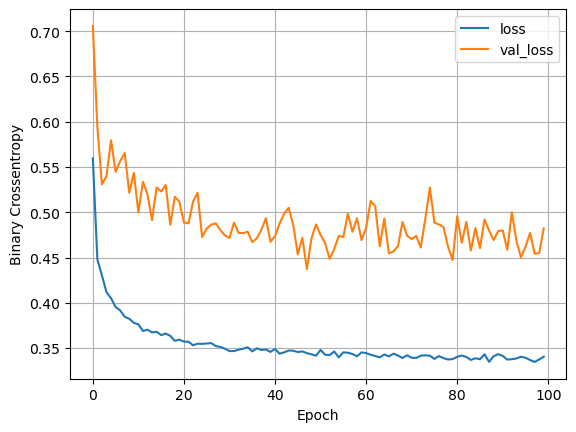

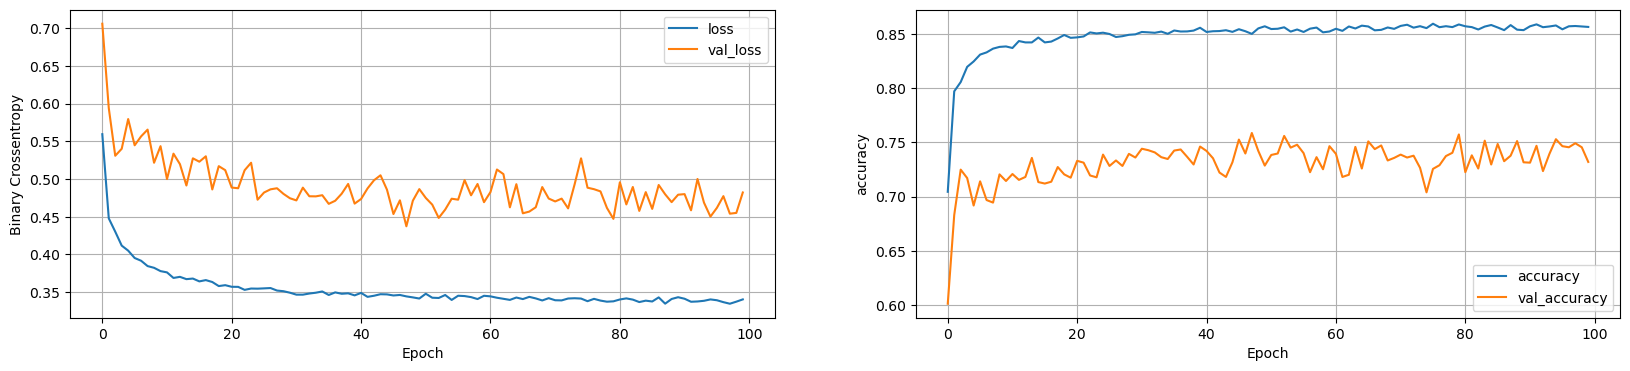

119/119 [==============================] - 2s 16ms/step - loss: 0.3231 - accuracy: 0.8720
number of nodes = 16, dropout probability = 0.2, learning rate = 0.001, batch size = 64, epochs = 100


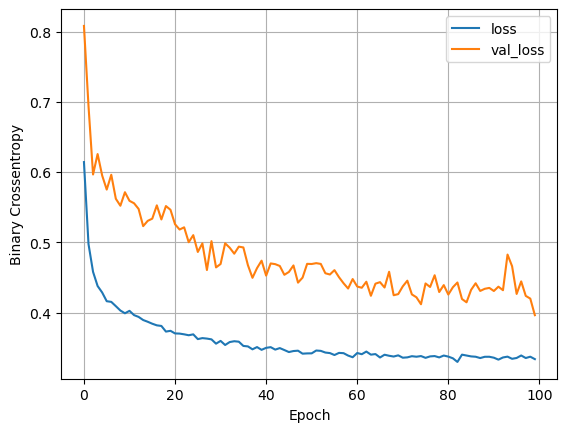

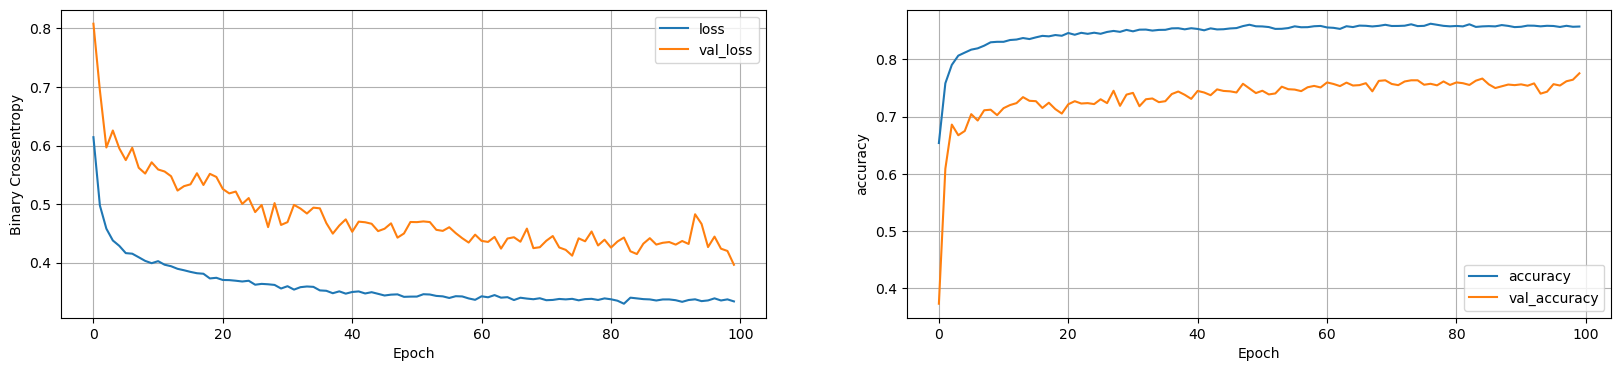

119/119 [==============================] - 1s 11ms/step - loss: 0.3252 - accuracy: 0.8651
number of nodes = 16, dropout probability = 0.2, learning rate = 0.001, batch size = 128, epochs = 100


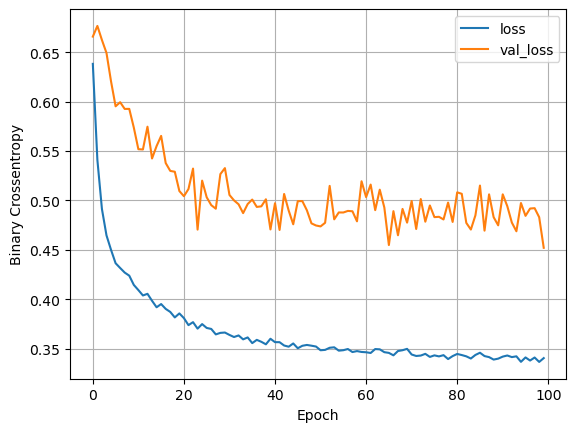

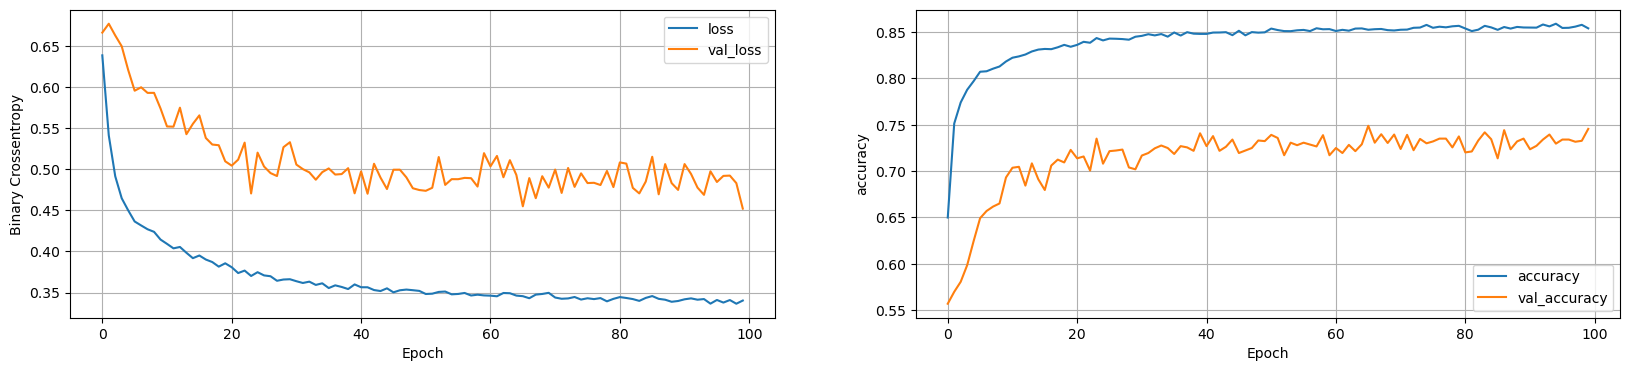

119/119 [==============================] - 2s 13ms/step - loss: 0.3221 - accuracy: 0.8686
number of nodes = 16, dropout probability = 0.2, learning rate = 0.005, batch size = 32, epochs = 100


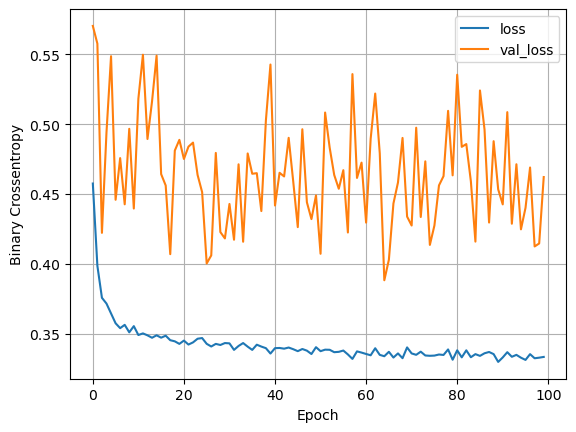

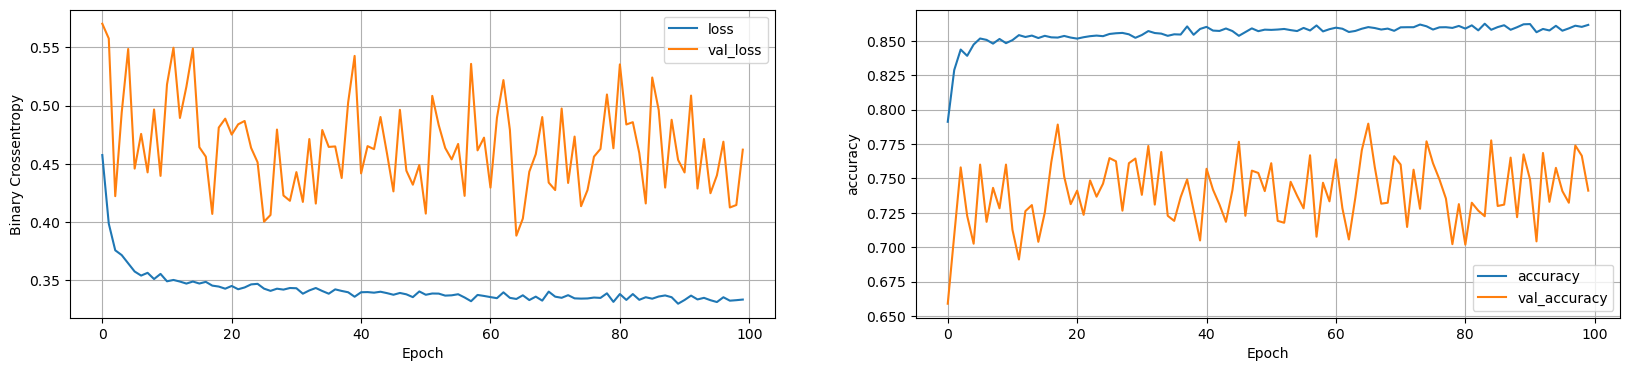

119/119 [==============================] - 2s 17ms/step - loss: 0.3167 - accuracy: 0.8720
number of nodes = 16, dropout probability = 0.2, learning rate = 0.005, batch size = 64, epochs = 100


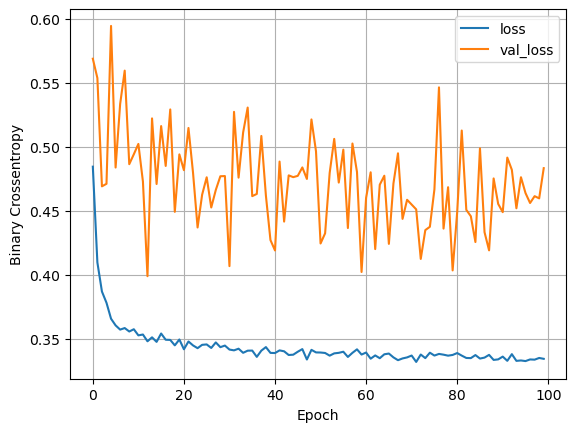

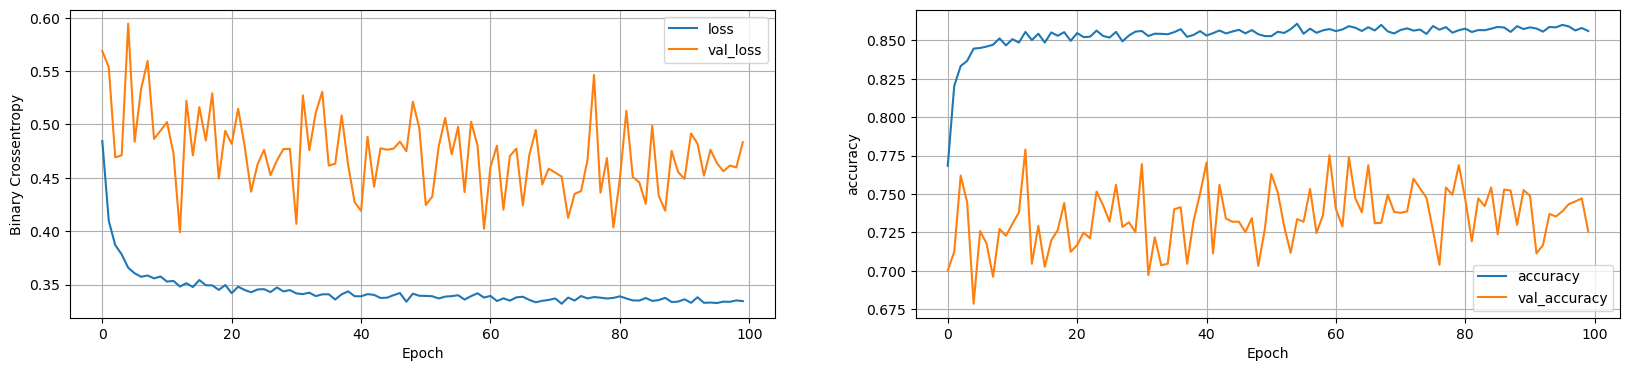

119/119 [==============================] - 2s 14ms/step - loss: 0.3175 - accuracy: 0.8707
number of nodes = 16, dropout probability = 0.2, learning rate = 0.005, batch size = 128, epochs = 100


In [ ]:
%%notify
least_val_loss = float('inf')
least_loss_model = None
epochs = 100
for num_nodes in [16,32,64]:
    for dropout_prob in [0,0.2]:
        for lr in [0.01,0.001,0.005]:
            for batch_size in[32,64,128]:
                print(f"number of nodes = {num_nodes}, dropout probability = {dropout_prob}, learning rate = {lr}, batch size = {batch_size}, epochs = {epochs}")
                model, history = train_model(x_train, y_train, num_nodes, dropout_prob, lr, batch_size, epochs)
                plot_loss(history)
                plot_history(history)
                val_loss = model.evaluate(x_valid, y_valid)[0]
                if val_loss < least_val_loss:
                    least_val_loss = val_loss
                    least_loss_model = model

In [ ]:
y_pred = least_loss_model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int).reshape(-1,)

In [ ]:
print(classification_report(y_test, y_pred))